In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression

import cvxpy as cp

from sklearn.model_selection import GridSearchCV

plt.rcParams.update({'font.size': 16})

In [2]:
X = pd.read_csv('./data/nsw_psid_X_small.csv', index_col=0)
T = pd.read_csv('./data/nsw_psid_T_small.csv', index_col=0)
Y = pd.read_csv('./data/nsw_psid_Y_small.csv', index_col=0)

In [3]:
Y = np.array(Y).reshape(-1)
T = np.array(T).reshape(-1)
X = np.array(X)

In [4]:
features = ["age", "educ", "black", "hisp", "mar", "re74", "re75", "agesq", "educsq", "re74sq", "re75sq"]

### separate control and treated groups

In [ ]:
Xp = X[T==0]
Xq = X[T==1]

yp = Y[T==0]

Xpc = Xp - Xp.mean(axis=0)
ypc = yp - yp.mean()

## lasso outcome model w/ cv

In [6]:
lasso_params = {'alpha':np.linspace(1e-8, 200, 100)}
lasso_cv = GridSearchCV(Lasso(max_iter=1200, fit_intercept=True), param_grid=lasso_params,cv=3).fit(Xpc, ypc)

c:\Users\david\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e+10, tolerance: 9.950e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.859e+09, tolerance: 4.788e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e+10, toleranc

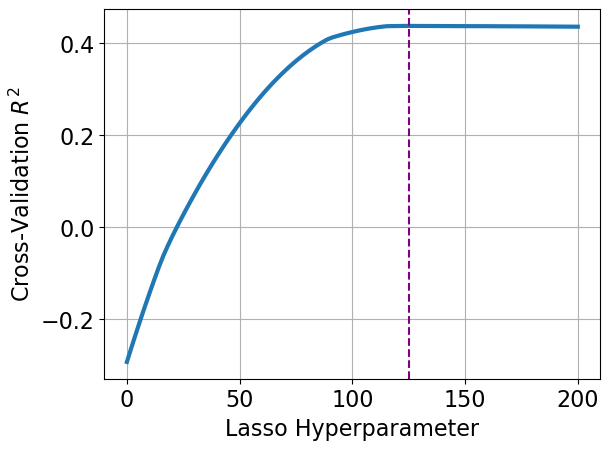

In [7]:
plt.plot(np.array(lasso_cv.cv_results_['param_alpha']) , np.array(lasso_cv.cv_results_['mean_test_score']), linewidth=3)
plt.axvline(lasso_cv.best_estimator_.alpha, color='purple', linestyle='--')
plt.xlabel("Lasso Hyperparameter")
plt.ylabel("Cross-Validation $R^2$")
plt.grid()

In [8]:
muhat = lasso_cv.best_estimator_

# Okay back to lasso on decorrelated features

In [12]:
Xqc = (Xq - Xp.mean(axis=0))
Xqb = Xqc.mean(axis=0)

In [13]:
def bal_square(Xp,Xqb,delta):

    N=Xp.shape[0]
    M=Xp.shape[1]

    w = cp.Variable(N)

    prob = cp.Problem(cp.Minimize(cp.sum_squares(w))/(N**2), [cp.norm( (w@Xp)/N - Xqb , 'inf')<=delta, cp.sum(w)/N==1])
    
    optimal_value = prob.solve()
    #print("t=",t.value)
    #print("x=",x.value)
    #print("val=",optimal_value)
    return(w.value)

def bal_entropy(Xp,Xqb,delta):

    N=Xp.shape[0]
    M=Xp.shape[1]

    w = cp.Variable(N)

    prob = cp.Problem(cp.Minimize( cp.sum( -cp.entr(w) )/(N) ), [cp.norm( (w@Xp)/N - Xqb , 'inf')<=delta, cp.sum(w)==N])
    
    optimal_value = prob.solve()
    #print("t=",t.value)
    #print("x=",x.value)
    #print("val=",optimal_value)
    return(w.value)

In [14]:
N = Xp.shape[0]

In [15]:
w_exact = bal_square(Xpc,Xqb,0)/N

In [16]:
w_exact_e = bal_entropy(Xpc,Xqb,0)/N

## Compare results to OLS

In [18]:
ols = LinearRegression(fit_intercept=False).fit(Xpc,ypc).coef_

In [23]:
resids = ypc - Xpc@ols

In [25]:
proj = w_exact_e - LinearRegression().fit(Xpc, w_exact_e).predict(Xpc)

In [29]:
bound = np.linalg.norm(resids) * np.linalg.norm(w_exact_e)

# Now repeat for inverse prop

In [31]:
ehat = LogisticRegression(penalty='none').fit(X,T).predict_proba(X[T==0])
pt1_x = ehat[:, 1]
pt1 = T.mean()
ipw = (pt1_x/(1-pt1_x)) * ( (1-pt1)/pt1 ) / N
ipw_proj = ipw - LinearRegression().fit(Xpc, ipw).predict(Xpc)

# Scan over delta

In [37]:
beta_reg = muhat.coef_

In [38]:
deltas = np.linspace(0,0.73134066, 40)

aug_ols_dist = []
ols_approx = []
final_approx = []

for delta in deltas:
    w_ent = bal_entropy(Xpc,Xqb,delta)/N
    
    proj = w_ent - LinearRegression().fit(Xpc, w_ent).predict(Xpc)
    
    phiqhat = w_ent @ Xpc
    a = phiqhat/Xqb
    beta_aug = muhat.coef_*(1-a) + a*ols
    
    ols_approx.append( proj @ resids )
    aug_ols_dist.append( (Xqb@ols) - (Xqb@beta_aug) )
    
    aug_est = Xqb@beta_reg + w_ent@(ypc - Xpc@beta_reg)
    final_approx.append((Xqb@ols) - aug_est)

In [39]:
np.abs(ols_approx) + np.abs(aug_ols_dist)

array([206.24877713, 231.61457622, 282.86943143, 323.53619348,
       355.85948346, 381.71516866, 392.94748289, 394.29044157,
       404.02899376, 421.21033086, 437.01680627, 448.09793431,
       457.49124054, 466.80929439, 476.32518385, 486.25362987,
       496.76017107, 507.96880351, 519.96823391, 532.81706079,
       546.54805554, 561.17162502, 576.67858959, 599.71263581,
       626.29164041, 652.34297687, 677.24149402, 701.0299242 ,
       723.73987191, 745.39048487, 765.98769101, 785.52400667,
       803.97955452, 821.32471854, 837.52487883, 852.21465622,
       861.97511905, 871.03884515, 879.38967166, 887.18576122])

In [40]:
deltas_ipw = np.linspace(0.000000001,65, 40)

aug_ols_dist_ipw = []
ols_approx_ipw = []
final_approx_ipw = []

for delta in deltas_ipw:
    
    ehat = LogisticRegression(penalty='l1', C=1/delta, solver='liblinear').fit(X,T).predict_proba(X[T==0])
    pt1_x = ehat[:, 1]
    pt1 = T.mean()
    ipw = (pt1_x/(1-pt1_x)) * ( (1-pt1)/pt1 ) / N
    ipw_proj = ipw - LinearRegression().fit(Xpc, ipw).predict(Xpc)

    phiqhat = ipw @ Xpc
    a = phiqhat/Xqb
    beta_aug = muhat.coef_*(1-a) + a*ols
    
    ols_approx_ipw.append( ipw_proj @ resids )
    aug_ols_dist_ipw.append( (Xqb@ols) - (Xqb@beta_aug) )

    aug_est = Xqb@beta_reg + ipw@(ypc - Xpc@beta_reg)
    final_approx_ipw.append((Xqb@ols) - aug_est)

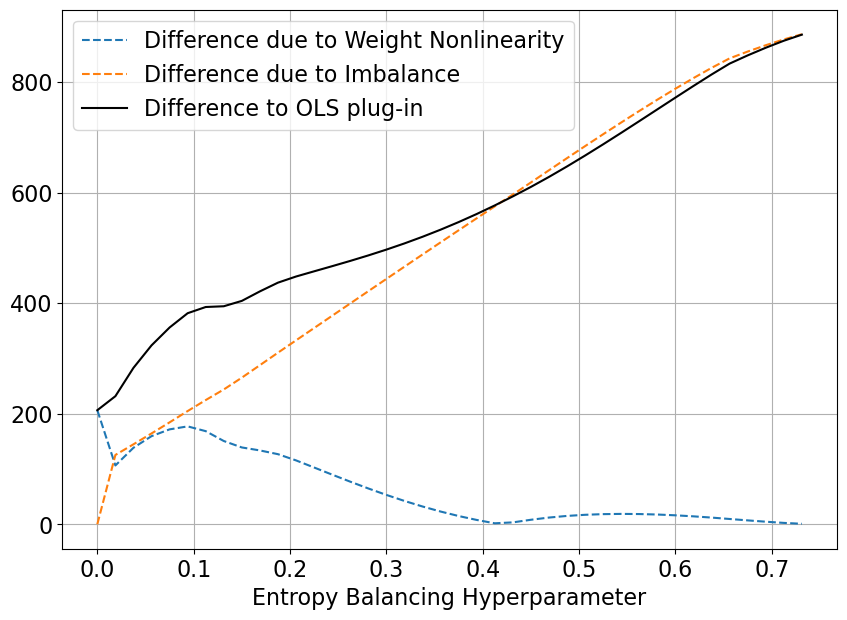

In [41]:
plt.figure(figsize=(10,7))
plt.plot(deltas, np.abs(ols_approx), label='Difference due to Weight Nonlinearity', linestyle='--')
plt.plot(deltas, np.abs(aug_ols_dist), label='Difference due to Imbalance', linestyle='--')
plt.plot(deltas, np.abs(final_approx), label='Difference to OLS plug-in', color='black')
plt.xlabel("Entropy Balancing Hyperparameter")
plt.legend()
plt.grid()

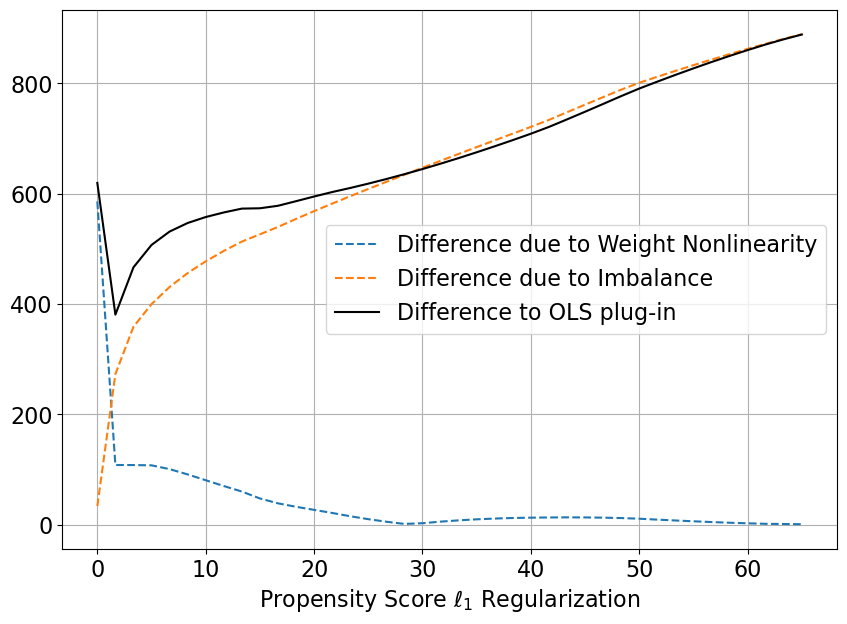

In [42]:
plt.figure(figsize=(10,7))
plt.plot(deltas_ipw, np.abs(ols_approx_ipw), label='Difference due to Weight Nonlinearity', linestyle='--')
plt.plot(deltas_ipw, np.abs(aug_ols_dist_ipw), label='Difference due to Imbalance', linestyle='--')
plt.plot(deltas_ipw, np.abs(final_approx_ipw), label='Difference to OLS plug-in', color='black')
plt.xlabel("Propensity Score $\ell_1$ Regularization")
plt.legend()
plt.grid()